<a href="https://colab.research.google.com/github/janmlew/TensorFlow/blob/master/TensorFlow_C1W4_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports:

In [8]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import random

# Ungraded Lab: Effect of Compacted Images in Training
In this notebook, you will see how reducing the target size of the generator images will affect the architecture and performance of your model. This is a useful technique in case you need to speed up your training or save compute resources. Let's begin!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

As before, start downloading the train and validation sets:

In [9]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2023-09-09 15:21:19--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip.2’

horse-or-human.zip. 100%[===================>] 142.65M   260MB/s    in 0.5s    

2023-09-09 15:21:20 (260 MB/s) - ‘horse-or-human.zip.2’ saved [149574867/149574867]



In [10]:
# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2023-09-09 15:21:20--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘validation-horse-or-human.zip.1’

validation-horse-or 100%[===================>]  10.95M  --.-KB/s    in 0.05s   

2023-09-09 15:21:20 (202 MB/s) - ‘validation-horse-or-human.zip.1’ saved [11480187/11480187]



Then unzip them:

In [11]:
# Unzip training set
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')

# Unzip validation set
local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

Then define the directories containing the images:

In [12]:
# Directory with training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

You can check that the directories are not empty and that the train set has more images than the validation set:

In [13]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_hames = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_hames[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

TRAIN SET HORSES: ['horse37-0.png', 'horse40-2.png', 'horse40-7.png', 'horse50-4.png', 'horse44-2.png', 'horse16-2.png', 'horse40-0.png', 'horse02-8.png', 'horse32-2.png', 'horse33-6.png']
TRAIN SET HUMANS: ['human09-13.png', 'human15-10.png', 'human09-26.png', 'human01-29.png', 'human08-05.png', 'human16-29.png', 'human09-15.png', 'human15-27.png', 'human15-11.png', 'human14-28.png']
VAL SET HORSES: ['horse1-539.png', 'horse5-405.png', 'horse2-183.png', 'horse4-468.png', 'horse4-188.png', 'horse1-298.png', 'horse4-495.png', 'horse5-164.png', 'horse3-026.png', 'horse3-484.png']
VAL SET HUMANS: ['valhuman01-16.png', 'valhuman03-22.png', 'valhuman05-19.png', 'valhuman01-09.png', 'valhuman05-10.png', 'valhuman02-00.png', 'valhuman05-22.png', 'valhuman05-09.png', 'valhuman04-20.png', 'valhuman01-01.png']


In [14]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


# Build the Model
The model will follow the same architecture as before but they key difference is in the input_shape parameter of the first Conv2D layer. Since you will be compacting the images later in the generator, you need to specify the expected image size here. So instead of 300x300 as in the previous two labs, you specify a smaller 150x150 array.

In [15]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution (You can uncomment the 4th and 5th conv layers later to see the effect)
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fifth convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can see the difference from previous models when you print the model.summary(). As expected, there will be less inputs to the Dense layer at the end of the model compared to the previous labs. This is because you used the same number of max pooling layers in your model. And since you have a smaller image to begin with (150 x 150), then the output after all the pooling layers will also be smaller.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

You will use the same settings for training:

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Data Preprocessing
Now you will instantiate the data generators. As mentioned before, you will be compacting the image by specifying the target_size parameter. See the simple change below:

In [18]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# Training
Now you're ready to train and see the results. Note your observations about how fast the model trains and the accuracies you're getting in the train and validation sets.

In [19]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 18s 786ms/step - loss: 1.1848 - accuracy: 0.5962 - val_loss: 0.8022 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 6s 802ms/step - loss: 0.6833 - accuracy: 0.6129 - val_loss: 0.6499 - val_accuracy: 0.5234
Epoch 3/15
8/8 [==============================] - 8s 963ms/step - loss: 0.5279 - accuracy: 0.7520 - val_loss: 0.6273 - val_accuracy: 0.7383
Epoch 4/15
8/8 [==============================] - 6s 805ms/step - loss: 0.3340 - accuracy: 0.8398 - val_loss: 0.7413 - val_accuracy: 0.7852
Epoch 5/15
8/8 [==============================] - 7s 915ms/step - loss: 0.3242 - accuracy: 0.8610 - val_loss: 0.6991 - val_accuracy: 0.7578
Epoch 6/15
8/8 [==============================] - 6s 809ms/step - loss: 0.1947 - accuracy: 0.9299 - val_loss: 1.6209 - val_accuracy: 0.6172
Epoch 7/15
8/8 [==============================] - 6s 808ms/step - loss: 0.1595 - accuracy: 0.9366 - val_loss: 1.0103 - val_accuracy: 0.8203
Epoch 8/15
8/8 [===

# Model Prediction
As usual, it is also good practice to try running your model over some handpicked images. See if you got better, worse, or the same performance as the previous lab.

<i>**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it.</i>

In [20]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving 66454594_2570328379692948_1115603873801699328_n.jpg to 66454594_2570328379692948_1115603873801699328_n.jpg
1/1 [==============================] - 0s 246ms/step
[1.8545363e-05]
66454594_2570328379692948_1115603873801699328_n.jpg is a horse


# Visualizing Intermediate Representations
You can also look again at the intermediate representations. You will notice that the output at the last convolution layer is even more abstract because it contains fewer pixels than before.

1/1 [==============================] - 0s 152ms/step


<ipython-input-21-1148f39dcddc>:42: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


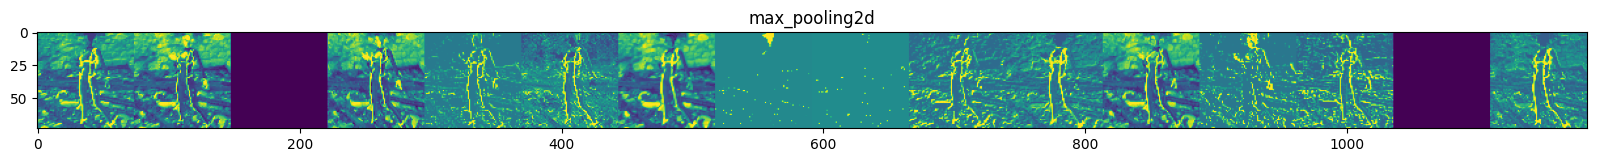

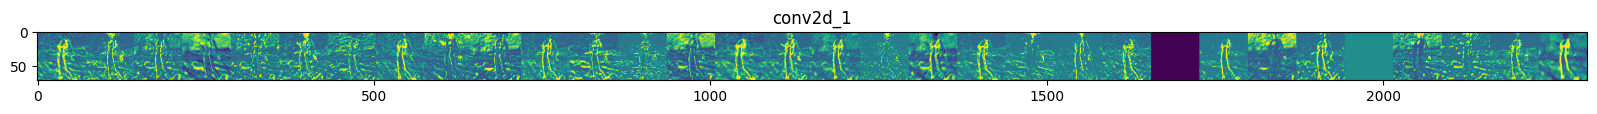

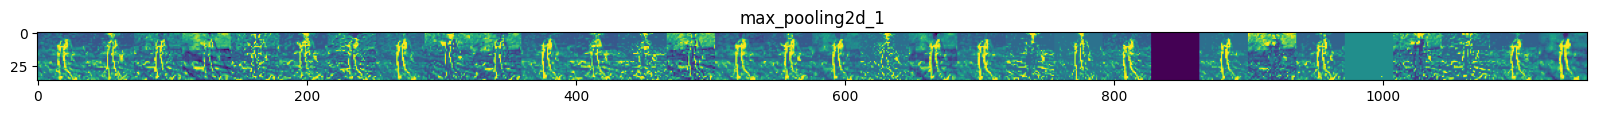

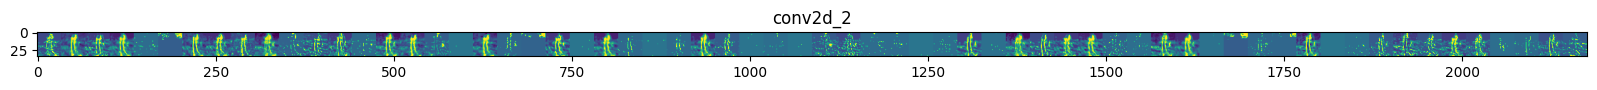

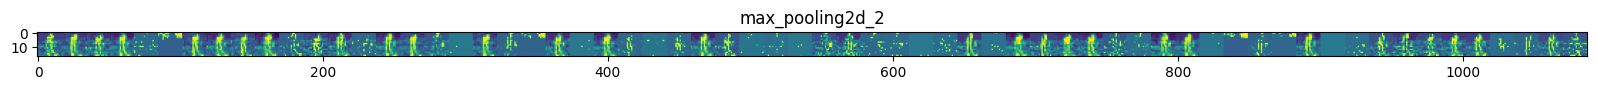

In [21]:
%matplotlib inline

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Wrap Up
In this lab, you saw how compacting images affected your previous model. This is one technique to keep in mind especially when you are still in the exploratory phase of your own projects. You can see if a smaller model behaves just as well as a large model so you can have faster training. You also saw how easy it is to customize your images for this adjustment in size by simply changing a parameter in the ImageDataGenerator class.